Data from Ratcliff and Rouder ([1998](https://journals.sagepub.com/doi/10.1111/1467-9280.00067)), experiment 1, participant N.H.:

> subjects were asked to decide whether the overall brightness of pixel arrays displayed on a computer monitor was “high” or “low” (Fig.\ 3a). The brightness of a display was controlled by the proportion of the pixels that were white. For each trial, the proportion of white pixels was chosen from one of two distributions, a high distribution or a low distribution, each with fixed mean and standard deviation (Fig. 3b). Feedback was given after each trial to tell the subject whether his or her decision had correctly indicated the distribution

There are 66 cells in the design.  1-33 had an accuracy instruction, 34-66 a speed instruction.  1-16 and 34-49 had more black pixels and 18-33 and 51-66 had more white.  17 and 50 were ambiguous and will not be used here.

In [1]:
import pandas as pd
import numpy as np
import pyjags
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load the data (tab-delimited) from one participant
data = pd.read_csv('nh.tsv', sep='\t', 
                   names=["index", "cond", "response", "RT"])
print(data)

      index  cond  response   RT
0         1     1         1  459
1         1     1         1  457
2         1     1         1  569
3         1     1         1  390
4         1     1         1  534
...     ...   ...       ...  ...
7885      1    66         2  261
7886      1    66         2  333
7887      1    66         1  261
7888      1    66         2  351
7889      1    66         2  361

[7890 rows x 4 columns]


In [3]:
# Remove rows where the value in the 'RT' column is greater than 3000ms
data = data[data['RT'] <= 3000]

# Update the 'response' column based on conditions, so it reflects accuracy
data['response'] = (
    ((data['cond'] >  0) & (data['cond'] < 17) & (data['response'] == 1)) |
    ((data['cond'] > 17) & (data['cond'] < 34) & (data['response'] == 2)) |
    ((data['cond'] > 33) & (data['cond'] < 50) & (data['response'] == 1)) |
    ((data['cond'] > 50) & (data['cond'] < 67) & (data['response'] == 2))
).astype(int)

In [4]:
# Initialize the output DataFrame
df = pd.DataFrame(np.zeros((66, 6)), 
                  columns=["nTrials",
                           "sum_accuracy",
                           "mean_rt_correct",
                           "variance_rt_correct",
                           "Xi",
                           "Xs"])

In [5]:
# Function to compute the summary statistics used by EZ
def ez_summaries(subset):
    return [
        len(subset),
        subset['response'].sum(),
        subset['RT'].mean() / 1000,
        (subset['RT'] / 1000).var(),
        int(subset.iloc[0]['cond'] > 33)-0.5,
        ((subset.iloc[0]['cond'] - 1) % 33 - 16) / 5  # Arbitrary rescaling
    ]

In [6]:
# Populate the output DataFrame using the ez_summaries function
for r in range(1, 67):
    df.iloc[r-1, :] = ez_summaries(data[data['cond'] == r])

# Remove the two ambiguous conditions (17 and 50)
df = df[df.iloc[:, -1] != 0]

# PyJAGS format
toJags = {
            "nTrials": df.nTrials,
            "meanRT":  df.mean_rt_correct,
            "varRT":   df.variance_rt_correct,
            "correct": df.sum_accuracy,
            "Xi":      df.Xi,
            "Xs":      df.Xs,
        }

EZ JAGS code with an effect of instruction (`Xi`) on bound and a nonlinear regression using `Xi` and stimulus intensity `Xs`.  Note the predictor is the absolute value of `Xs` to capture that the task gets easier as the black/white balance departs from 50%.

`Beta3` captures the effect of instruction on drift rate and is of specific interest.

In [7]:
code = """
# JAGS implementation of the EZ Bayesian 
# hierarchical drift diffusion model
model {
  # Priors for hierarchical drift diffusion model
  # parameters
  betaweight ~ dnorm(0.00, 1.00)
  beta0 ~ dnorm(0.00, 1.00)
  beta1 ~ dnorm(0.00, 1.00)
  beta2 ~ dnorm(0.00, 1.00)
  beta3 ~ dnorm(0.00, 1.00)
  beta4 ~ dnorm(0.00, 1.00)
  bound_mean ~ dnorm(1.50, (0.20^-2))T( 0.10, 3.00)
  drift_mean ~ dnorm(0.50, (0.50^-2))
  nondt_mean ~ dnorm(0.30, (0.06^-2))T( 0, )
  bound_sdev ~ dunif(0.01, 1.00)
  drift_sdev ~ dunif(0.01, 3.00)
  nondt_sdev ~ dunif(0.01, 0.50)

  for (p in 1:length(meanRT)) {
    # Hierarchical distributions of person-specific
    # diffusion model parameters.  Here, drift rate
    # is the criterion.
    drift_pred[p] = beta0*phi(beta1 + beta2*abs(Xs[p]) + beta4*Xi[p]*abs(Xs[p]))
                  + beta3 * Xi[p] + drift_mean
    drift[p] ~ dnorm(drift_pred[p], (drift_sdev^-2))
    bound[p] ~ dnorm(bound_mean + betaweight * Xi[p],
                    (bound_sdev^-2))T( 0.10, 3.00)
    nondt[p] ~ dnorm(nondt_mean, (nondt_sdev^-2))
                                    T( 0.05, )

    # Forward equations from EZ Diffusion
    ey[p]  = exp(-bound[p] * drift[p])
    Pc[p]  = 1 / (1 + ey[p])
    PRT[p] = 2 * pow(drift[p], 3) / bound[p] * 
             pow(ey[p] + 1, 2) / (2 * -bound[p] * 
             drift[p] * ey[p] - ey[p] * ey[p] + 1)
    MDT[p] = (bound[p] / (2 * drift[p])) * 
             (1 - ey[p]) / (1 + ey[p])
    MRT[p] = MDT[p] + nondt[p]

    # Sampling distributions for summary statistics
    correct[p] ~ dbin(Pc[p], nTrials[p])
    varRT[p]   ~ dnorm(1/PRT[p], 0.5*(correct[p]-1) 
                                 * PRT[p] * PRT[p])
    meanRT[p]  ~ dnorm(MRT[p], PRT[p] * correct[p])
  }
}
"""

In [8]:
# Initial values for JAGS
init = { "drift" : np.random.normal(0, 0.1, len(toJags['nTrials'])) }

# Call JAGS and draw samples
model = pyjags.Model(
            progress_bar = True,
            code    = code,
            data    = toJags,
            init    = init,
            adapt   = 1000,
            chains  = 4,
            threads = 4)

# Overkill number of samples, takes a few seconds
samples = model.sample(4000, vars = ['beta3', 'beta4', 'drift', 'drift_pred'])

adapting: iterations 4000 of 4000, elapsed 0:00:02, remaining 0:00:00
sampling: iterations 9127 of 16000, elapsed 0:00:08, remaining 0:00:06
sampling: iterations 16000 of 16000, elapsed 0:00:09, remaining 0:00:00


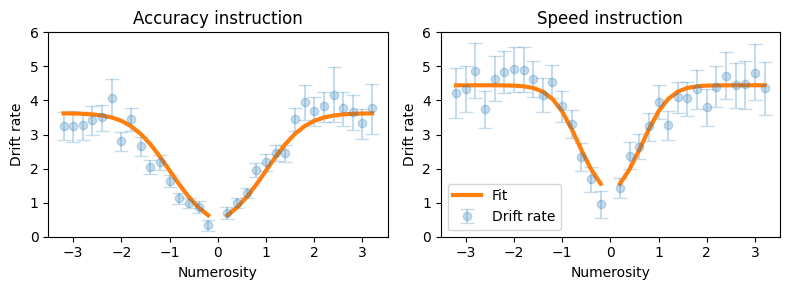

In [9]:
# Extract samples for plotting the nonlinear regression
drift = samples['drift']
means = np.mean(drift, axis=(1, 2))
preds = np.mean(samples['drift_pred'], axis=(1, 2))

lower_percentiles = np.percentile(drift,  2.5, axis=(1, 2))
upper_percentiles = np.percentile(drift, 97.5, axis=(1, 2))

results = np.array([means, lower_percentiles, upper_percentiles, preds]).T

# X-values
x_values = df.Xs[df.Xi>0]

# Calculate the errors for the error bars (distance from mean to CI limits)
acccy = results[:32]
speed = results[-32:]
errors_acccy = [acccy[:, 0] - acccy[:, 1], acccy[:, 2] - acccy[:, 0]]
errors_speed = [speed[:, 0] - speed[:, 1], speed[:, 2] - speed[:, 0]]

# Fit line needs a break
fit_line_acccy = np.concatenate([acccy[:16, 3], [None], acccy[16:, 3]])
fit_line_speed = np.concatenate([speed[:16, 3], [None], speed[16:, 3]])
x_values_fit_line = np.concatenate([x_values[:16], [None], x_values[16:]])

# Plotting
plt.figure(figsize=(8, 3))

# Plot for the accuracy instruction condition
plt.subplot(1, 2, 1)
plt.errorbar(x_values, acccy[:, 0], yerr=errors_acccy, 
             fmt='o', capsize=5, label='Drift rate', alpha=.25)
plt.plot(x_values_fit_line, fit_line_acccy, label='Fit', linewidth=3)
plt.title('Accuracy instruction')
plt.xlabel('Numerosity')
plt.ylabel('Drift rate')
plt.ylim((0,6))

# Plot for the speed instruction condition
plt.subplot(1, 2, 2)
plt.errorbar(x_values, speed[:, 0], yerr=errors_speed, 
             fmt='o', capsize=5, label='Drift rate', alpha=.25)
plt.plot(x_values_fit_line, fit_line_speed, label='Fit', linewidth=3)
plt.title('Speed instruction')
plt.xlabel('Numerosity')
plt.ylabel('Drift rate')
plt.ylim((0,6))
plt.legend()

plt.tight_layout()
plt.show()


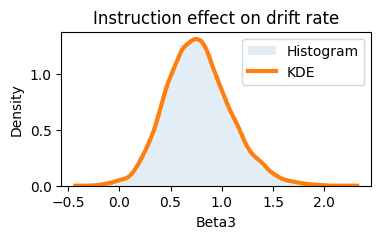

In [10]:
# Now focus on beta3
beta3 = samples['beta4'].flatten()

# Plotting
plt.figure(figsize=(4, 2))

# Histogram
plt.hist(beta3, bins=31, alpha=0.125, density=True, label='Histogram')

# Kernel density estimate
sns.kdeplot(beta3, linewidth=3, label='KDE')

plt.title('Instruction effect on drift rate')
plt.xlabel('Beta3')
plt.ylabel('Density')
plt.legend()

plt.show()
